In [ ]:
# Montando o Google Drive

from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Bibliotecas gerais
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Bibliotecas CNN
import keras
import tensorflow as tf
import cv2

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.image import resize

In [ ]:
# Lendo as imagens
import glob

def ler(file_list, imagens):
  for file in file_list:
      img = cv2.imread(file)  
      #img = tf.image.rgb_to_grayscale(img)  # Conversão para escala de cinza
      img = tf.image.resize(img,[64,64])    # Mudando as dimensões da imagem
      imagens.append(img)
  return imagens  

In [ ]:
img_saudavel = []  
img_doente = []

file_list = glob.glob(r'gdrive/My Drive/Dataset/Batata/color/saudavel/*.*')
img_saudavel = np.array(ler(file_list, img_saudavel))

file_list = glob.glob(r'gdrive/My Drive/Dataset/Batata/color/doente/*.*')
img_doente = ler(file_list, img_doente)

file_list = glob.glob(r'gdrive/My Drive/Dataset/Batata/color/Early_Blight/*.*')
img_doente = np.array(ler(file_list, img_doente))

In [ ]:
print(img_saudavel.shape)
print(img_doente.shape)

(152, 64, 64, 3)
(2000, 64, 64, 3)


#### Pré-processamento

In [ ]:
# Data augmentation nas imagens de folhas saudáveis
def augmentation(imagens):
  aug = tf.image.flip_left_right(imagens)
  imagens = np.concatenate((imagens,aug))
  aug = tf.image.random_brightness(aug,max_delta = 0.35)
  imagens = np.concatenate((imagens,aug))
  aug = tf.image.random_contrast(aug, 0.3, 2.5)
  imagens = np.concatenate((imagens,aug))
  return(np.array(imagens))

In [ ]:
from sklearn.model_selection import train_test_split

img_saudavel_aug = augmentation(img_saudavel)
img_saudavel_aug = augmentation(img_saudavel_aug)

img_doente_aug = augmentation(img_doente)

x = np.array([*img_saudavel_aug,*img_doente_aug])
y = np.array([*np.zeros(len(img_saudavel_aug)),*np.ones(len(img_doente_aug))])     # 0 = saudável, 1 = doente

#x = np.array([*img_saudavel,*img_doente])
#y = np.array([*np.zeros(len(img_saudavel)),*np.ones(len(img_doente))])

xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2)
xtrain, xval, ytrain, yval = train_test_split(xtrain,ytrain,test_size=0.2) # Validação

xtrain.shape, xtest.shape, xval.shape

((6676, 64, 64, 3), (2087, 64, 64, 3), (1669, 64, 64, 3))

In [ ]:
img_saudavel_aug.shape, img_doente.shape

((2432, 64, 64, 3), (2000, 64, 64, 3))

### Modelo

In [ ]:
# Criando o modelo
from tensorflow.keras import Input
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

shape = (64,64,3)

resnet = ResNet50(weights=None, include_top=False)

input = Input(shape=shape)

# Pré-Processamento
x = preprocess_input(input)
x = RandomFlip('vertical')(input)
x = RandomRotation(0.5)(x)
x = RandomZoom(0.2)(x)

# Modelo Base
x = resnet(x)

# Output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.7)(x)
out = Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs=input, outputs=out)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 64, 64, 3)         0         
                                                                 
 random_rotation_1 (RandomRo  (None, 64, 64, 3)        0         
 tation)                                                         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 512)               1049

In [ ]:
# Compilando o modelo
opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
model.compile(optimizer=opt, 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [ ]:
# Treinando o modelo
batch = 32
epocas = 30
history = model.fit(xtrain, ytrain, 
                    validation_data = (xtest,ytest), 
                    batch_size = batch, 
                    epochs = epocas
                    )

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


209/209 [==============================] - 20s 69ms/step - loss: 0.7218 - accuracy: 0.7325 - val_loss: 0.5144 - val_accuracy: 0.7887
Epoch 2/30
209/209 [==============================] - 14s 66ms/step - loss: 0.4779 - accuracy: 0.7852 - val_loss: 0.3777 - val_accuracy: 0.8232
Epoch 3/30
209/209 [==============================] - 14s 66ms/step - loss: 0.3958 - accuracy: 0.8177 - val_loss: 0.3152 - val_accuracy: 0.8625
Epoch 4/30
209/209 [==============================] - 14s 66ms/step - loss: 0.3493 - accuracy: 0.8427 - val_loss: 0.2943 - val_accuracy: 0.8816
Epoch 5/30
209/209 [==============================] - 14s 66ms/step - loss: 0.3189 - accuracy: 0.8553 - val_loss: 0.2572 - val_accuracy: 0.9018
Epoch 6/30
209/209 [==============================] - 14s 66ms/step - loss: 0.2909 - accuracy: 0.8775 - val_loss: 0.2329 - val_accuracy: 0.9023
Epoch 7/30
209/209 [==============================] - 16s 78ms/step - loss: 0.2629 - accuracy: 0.8917 - val_loss: 0.2098 - val_accuracy: 0.9224
Epo

In [ ]:
model.save('gdrive/My Drive/Dataset/Batata/Resultados_Resnet')

INFO:tensorflow:Assets written to: gdrive/My Drive/Dataset/Batata/Resultados_Resnet/assets


In [ ]:
import pickle
with open('gdrive/My Drive/Dataset/Batata/Resultados_Resnet/trainHistoryDict', 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

#### Avaliando o modelo

In [ ]:
model = keras.models.load_model('gdrive/My Drive/Dataset/Batata/Resultados_Resnet')
#history = pickle.load(open('gdrive/My Drive/Dataset/Batata/Resultados_Resnet/trainHistoryDict', "rb"))

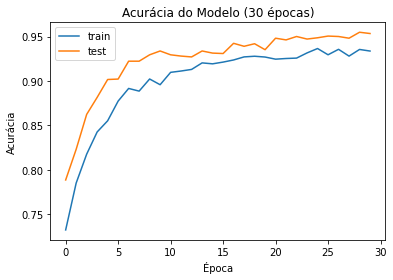

In [ ]:
# Acurácia
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Acurácia do Modelo ({epocas} épocas)')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['train', 'test'], loc='upper left')

plt.savefig("acuracia.png", dpi = 300)
!cp acuracia.png "gdrive/My Drive/Dataset/Batata/Resultados_Resnet"

plt.show()

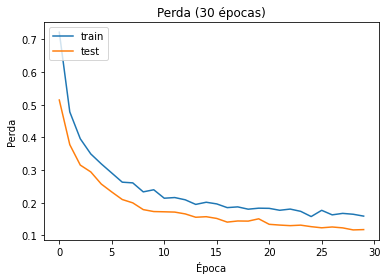

In [ ]:
# Perda
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Perda ({epocas} épocas)')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['train', 'test'], loc='upper left')

plt.savefig("perda.png", dpi = 300)
!cp perda.png "gdrive/My Drive/Dataset/Batata/Resultados_Resnet"

plt.show()

In [ ]:
ypred = model.predict(xtest)

In [ ]:
# Matriz de Confusão
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

array = confusion_matrix(ytest,np.round(ypred))

print(array)
print('\nAcurácia:',accuracy_score(ytest, np.round(ypred)))

[[ 419   45]
 [  52 1571]]

Acurácia: 0.9535218016291327


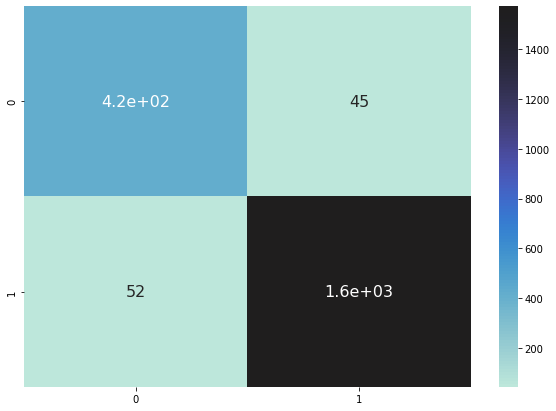

In [ ]:
import pandas as pd
import seaborn as sn
from matplotlib.pyplot import figure

df_cm = pd.DataFrame(array, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, center = np.amax(array))

plt.savefig("conf_mlp.png", dpi = 300, transparent = True)
!cp conf_mlp.png "gdrive/My Drive/Dataset/Batata/Resultados_Resnet/"

plt.show()

#### Fazendo previsões

In [ ]:
# Dataset de validação
ypred = model.predict(xval)
array = confusion_matrix(yval, np.round(ypred))

print(array)
print('\nAcurácia:',accuracy_score(yval, np.round(ypred)))

[[ 307   50]
 [  40 1272]]

Acurácia: 0.9460754943079689


In [ ]:
# Testando com imagens individuais (folhas saudáveis)
def ler_imagem(file_list):
  img = cv2.imread(file_list)
  img = np.array(tf.image.resize(img,[64,64]))
  img = img.reshape(1,64,64,3)
  return(img)

file_list = 'gdrive/My Drive/Dataset/Batata/folha_saudavel_1.png'
batata_1 = ler_imagem(file_list)

file_list = 'gdrive/My Drive/Dataset/Batata/folha_saudavel_2.png'
batata_2 = ler_imagem(file_list)

file_list = 'gdrive/My Drive/Dataset/Batata/folha_saudavel_3.png'
batata_3 = ler_imagem(file_list)

file_list = 'gdrive/My Drive/Dataset/Batata/folha_saudavel_4.jpg'
batata_4 = ler_imagem(file_list)

In [ ]:
print(model.predict(batata_1))
print(model.predict(batata_2))
print(model.predict(batata_3))
print(model.predict(batata_4))

[[0.13672963]]
[[0.99924326]]
[[0.81376004]]
[[0.66289777]]


In [ ]:
# Testando com novas imagens

val_saudavel = [] 
val_doente = []

file_list = glob.glob(r'gdrive/My Drive/Dataset/Batata_val/Healthy/*.*')
val_saudavel = ler(file_list, val_saudavel)

file_list = glob.glob(r'gdrive/My Drive/Dataset/Batata_val/Late_Blight/*.*')
val_doente = ler(file_list, val_doente)

file_list = glob.glob(r'gdrive/My Drive/Dataset/Batata_val/Late_Blight/*.*')
val_doente = ler(file_list, val_doente)

x_novo = np.array([*val_saudavel,*val_doente])
ypred = model.predict(x_novo)

ytest_val = np.array([*np.zeros(len(val_saudavel)),*np.ones(len(val_doente))])   

array = confusion_matrix(ytest_val, np.round(ypred))

print(array)
print('\nAcurácia:',accuracy_score(ytest_val, np.round(ypred)))

[[  9  93]
 [  6 276]]

Acurácia: 0.7421875
